In [3]:
import pandas as pd
import re
import nltk
import string
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from num2words import num2words

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data_df = pd.read_csv('train_preprocess.tsv.txt', names = ['Text','Sentiment'], sep = '\t')
data_df.drop_duplicates()

,Text,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10993,f - demokrat dorong upaya kemandirian energi n...,neutral
10994,tidak bosan,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [4]:
alay_df = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_filter = dict(zip(alay_df[0], alay_df[1]))

In [ ]:
# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r'\\t|\\n|\\u', ' ', text) #Menghapus karakter khusus seperti tab, baris baru, karakter Unicode, dan backslash.
#     text = re.sub(r"https?:[^\s]+", ' ', text)  # Menghapus http / https
#     text = re.sub(r"[^\w\s+]", '', text)  # Menghapus karakter kecuali huruf, angka, dan spasi
#     text = re.sub(r'rt|user', ' ', text)  # Menghapus kata-kata 'rt' dan 'user'
#     text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)  # Menghapus karakter yang dimulai dengan '\x' diikuti oleh dua karakter huruf atau angka
#     text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
#     text = text.replace('_', ' ')  # Menghapus underscore
#     text = re.sub(r'(\d+)', r' \1 ', text)  # Memisahkan angka dari teks
#     text = re.sub(r'\s+', ' ', text).strip()  # Menggabungkan spasi berturut-turut menjadi satu spasi
#     text = re.sub(r'(\d+)', lambda x: num2words(int(x.group(0)), lang='id'), text)  # Mengonversi angka menjadi kata
#     return text

# def normalisasi_alay(text):
#     return ' '.join(alay_filter.get(word, word) for word in text.split(' '))

# # Fungsi untuk menghilangkan stopwords
# def remove_stopwords(text):
#     return ' '.join(word for word in text.split() if word not in stop_words)

# # Fungsi untuk stemming
# def stem_text(text):
#     return stemmer.stem(text)

# # Fungsi untuk menggabungkan pembersihan, normalisasi, penghilangan stopwords, dan stemming
# def cleaning_text(text):
#     text = clean_text(text)
#     text = normalisasi_alay(text)
#     text = remove_stopwords(text)
#     text = stem_text(text)
#     return text

# # Terapkan fungsi pada kolom 'Text'
# data_df['Text_Cleansing'] = data_df['Text'].apply(cleaning_text)

# # Pilih kolom yang diinginkan
# data_df = data_df[['Text', 'Text_Cleansing', 'Sentiment']]
# data_df

# Text_Cleansing

In [5]:
def clean_text(text):
    text = re.sub(r'\\t|\\n|\\u', ' ', text) #Menghapus karakter khusus seperti tab, baris baru, karakter Unicode, dan backslash.
    text = re.sub(r"https?:[^\s]+", ' ', text)  # Menghapus http / https
    text = re.sub(r'(\b\w+)-\1\b', r'\1', text)
    text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)  # Menghapus karakter yang dimulai dengan '\x' diikuti oleh dua karakter huruf atau angka
    # text = re.sub(r'(\d+)', r' \1 ', text)  # Memisahkan angka dari teks
    text = re.sub(r'[^a-zA-Z]+', ' ', text)  # Menghapus karakter kecuali huruf, dan spasi
    text = re.sub(r'\brt\b|\buser\b', ' ', text) # Menghapus kata-kata 'rt' dan 'user'
    text = text.lower()
    return text

def normalisasi_alay(text):
    return ' '.join(alay_filter.get(word, word) for word in text.split(' '))

def cleaning_text(text):
    text = clean_text(text)
    text = normalisasi_alay(text)
    return text

data_df['Text_Cleansing'] = data_df['Text'].apply(cleaning_text)

# Pilih kolom yang diinginkan
data_df = data_df[['Text', 'Text_Cleansing', 'Sentiment']]
data_df

,Text,Text_Cleansing,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unbog paket d...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
...,...,...,...
10995,tidak kecewa,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,hormati partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",pagi pagi di tol pasteur sudah macet parah bik...,negative


# Text_Preprocessing

In [6]:
factory = StemmerFactory()
stemer = factory.create_stemmer()

list_stopwords = set(stopwords.words('indonesian'))

# Tokenizing
def tokenize(text):
    return word_tokenize(text)

# Removing stopwords
def remove_stopwords(text):
    return [word for word in text if not word in list_stopwords]

# Stemming
def stemming(text):
    return [stemer.stem(word) for word in text]

# Convert list of words to a sentence
def words_to_sentence(list_words):
    return ' '.join(list_words)

def text_preprocessing(text):
    text = tokenize(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = words_to_sentence(text)
    return text

In [7]:
# # Sudah berhasil Cleansing
# data_df['Text_Preprocessing'] = data_df['Text_Cleansing'].apply(text_preprocessing)

# # Pilih kolom yang diinginkan
# data_df = data_df[['Text', 'Text_Cleansing', 'Text_Preprocessing','Sentiment']]
# data_df

,Text,Text_Cleansing,Text_Preprocessing,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k mmbri hujjah partai ap...,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung temp...,lokasi strategis jalan sumatra bandung nya nya...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unbog paket d...,betapa bahagia nya unbog paket barang nya bagu...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh jadi mahasiswa jangan sombong dong kasih ...,aduh mahasiswa sombong kasih kartu kuning ajar...,negative
...,...,...,...,...
10995,tidak kecewa,tidak kecewa,kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,enak rasa masakan nya apalagi kepiting yang me...,enak masakan nya kepiting senang pilih kepitin...,positive
10997,hormati partai-partai yang telah berkoalisi,hormati partai yang telah berkoalisi,hormat partai koalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",pagi pagi di tol pasteur sudah macet parah bik...,pagi pagi tol pasteur macet parah bikin jengkel,negative


Menyimpan data menjadi csv

In [8]:
# Save to csv
data_df.to_csv('final_cleaned_data.csv', index=False)

In [ ]:
#create standardized dataset using standard scaler
stdscl = StandardScaler()
stdscl.fit(X_train)
X_train_std = stdscl.transform(X_train)
X_val_std = stdscl.transform(X_val)

# Feature Extractions : Bag of Word

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

# Proses FeatureExtraction
count_vect = CountVectorizer()
count_vect.fit(data_preprocessed) # fit untuk mengambil informasi yang kita punya

X= count_vect.transform(data_preprocessed) # transfor untuk mengubah informasi yang kita punya
print('Features Extraction selesai')
print(count_vect.get_feature_names_out())
print(X.toarray())

Features Extraction selesai
['aakan' 'aan' 'aape' ... 'zupa' 'zuppa' 'zwitsal']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [51]:
import pickle

pickle.dump(count_vect, open('features.p','wb'))

# Splitting Dataset

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df_label, test_size=0.2, random_state=123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.toarray())

(8794, 12281) (2199, 12281) (8794,) (2199,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Modelling with LSTM

In [53]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [56]:
# Tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_preprocessed)
X_sequences = tokenizer.texts_to_sequences(data_preprocessed)

In [61]:
max_features = 10000
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 3)

In [26]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [27]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [19]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [29]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 299ms/step - accuracy: 0.6858 - loss: 0.7650 - val_accuracy: 0.8336 - val_loss: 0.4244
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 287ms/step - accuracy: 0.8776 - loss: 0.3361 - val_accuracy: 0.8782 - val_loss: 0.3211
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 47s 269ms/step - accuracy: 0.9320 - loss: 0.1939 - val_accuracy: 0.8727 - val_loss: 0.3402
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 259ms/step - accuracy: 0.9499 - loss: 0.1429 - val_accuracy: 0.8573 - val_loss: 0.3730
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - accuracy: 0.9631 - loss: 0.1073 - val_accuracy: 0.8418 - val_loss: 0.5113
Epoch 5: early stopping


In [30]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       648
           1       0.85      0.59      0.70       239
           2       0.90      0.89      0.90      1313

    accuracy                           0.84      2200
   macro avg       0.83      0.77      0.79      2200
weighted avg       0.85      0.84      0.84      2200



In [32]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       648
           1       0.86      0.67      0.75       239
           2       0.88      0.95      0.92      1313

    accuracy                           0.87      2200
   macro avg       0.86      0.80      0.82      2200
weighted avg       0.86      0.87      0.86      2200



c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.75      0.85      0.79       648
           1       0.81      0.73      0.77       239
           2       0.92      0.87      0.90      1313

    accuracy                           0.85      2200
   macro avg       0.83      0.82      0.82      2200
weighted avg       0.86      0.85      0.85      2200



c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       648
           1       0.82      0.70      0.76       239
           2       0.89      0.94      0.91      1313

    accuracy                           0.86      2200
   macro avg       0.85      0.81      0.82      2200
weighted avg       0.86      0.86      0.86      2200



c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       648
           1       0.82      0.71      0.76       239
           2       0.90      0.93      0.92      1313

    accuracy                           0.87      2200
   macro avg       0.85      0.82      0.83      2200
weighted avg       0.87      0.87      0.87      2200



c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       648
           1       0.75      0.77      0.76       239
           2       0.90      0.93      0.91      1313

    accuracy                           0.86      2200
   macro avg       0.83      0.82      0.82      2200
weighted avg       0.86      0.86      0.86      2200




Rata-rata Accuracy:  0.8632727272727273


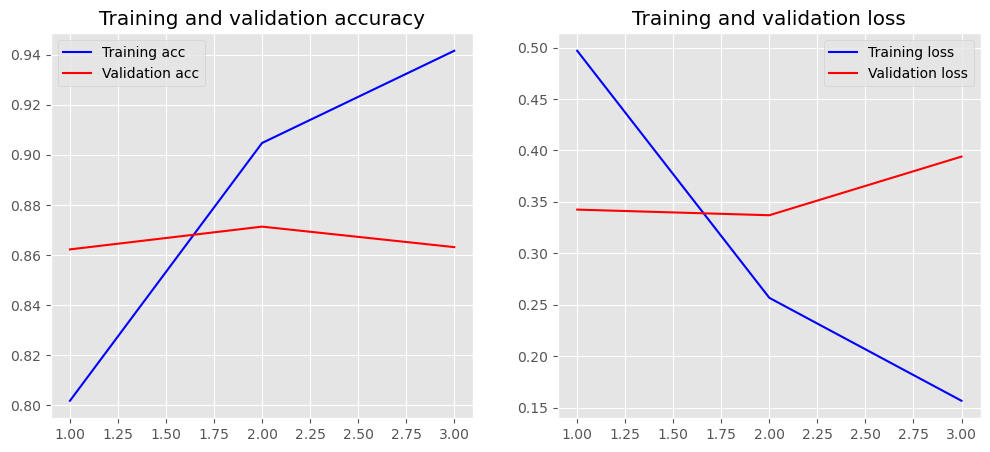

In [33]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [35]:
model.save('model.h5')
print("Model has created!")

Model has created!


In [42]:
import re
from keras.models import load_model

input_text = """
fadli zon anjing kau . tidak usah kau sok polos .
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Text:   fadli zon anjing kau   tidak usah kau sok polos   
Sentiment:  negative


Mengambil 101 baris pertama untuk fitur (X) dan label (y)

In [37]:
df_new = data_df[0:101] # variable X

df_label = data_df.Sentiment[0:101] # variable y
df_label

0      positive
1       neutral
2      positive
3      positive
4      negative
         ...   
96     negative
97     positive
98      neutral
99     negative
100    positive
Name: Sentiment, Length: 101, dtype: object

Simpan text ke dalam sebuah var

In [38]:
data_prepro = df_new.Text_Preprocessing.tolist()
data_prepro

['warung milik usaha pabrik puluh kenal putih bandung kualitas padu ahli masak padu kretivitas warung saji menu utama bahan tambah menu sepe i ayam selera indonesia harga jangkau lewat bletoka nya kalah asli tegal',
 'mohon ulama lurus k ratus belas mmbri hujjah ai diwlh suara islam pecahpecah',
 'lokasi strategis jalan sumatra bandung nya nyaman sofa lantai paella nya enak pas makan minum bir dingin appetiser nya enakenak',
 'betapa bahagia nya unbog paket barang nya bagus tetap beli',
 'aduh mahasiswa sombong kasih kakak kuning ajar usah ikutikut politik selesai kuliah nya politik telat dasar mahasiswa',
 'makan agam harga makan food stall puluh kasir suasana ramai perhati parkir duduk',
 'pakai kakak kredit baca untung rugi',
 'unik bagus foto makan enak pegawai ramah bersih luas wifi kencang harga standar sesuai nya menu masakan makan barat indonesia menu favorit lychee mojito spagheti',
 'keluarga nikmat alam kuliner senang rm sari sunda jalan setiabudhi bandung hubung rm sari sun

# Feature extraction : Bag of Word

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

# Proses FeatureExtraction
count_vect = CountVectorizer()
count_vect.fit(data_prepro) # fit untuk mengambil informasi yang kita punya

X= count_vect.transform(data_prepro) # transfor untuk mengubah informasi yang kita punya
print('Features Extraction selesai')
print(count_vect.get_feature_names_out())
print(X.toarray())

Features Extraction selesai
['abang' 'abuabu' 'abuba' 'acara' 'aceh' 'adek' 'adem' 'adil' 'aduh'
 'afdal' 'afrika' 'agam' 'agama' 'ahli' 'ai' 'air' 'ajar' 'akhlaq' 'akses'
 'aktif' 'ala' 'alam' 'alas' 'alhamdulillah' 'ali' 'allah' 'almamater'
 'alunalun' 'amal' 'amanda' 'ambil' 'amis' 'an' 'anak' 'anakanak' 'andal'
 'anggrek' 'anggung' 'angkat' 'anies' 'anjis' 'anya' 'aplikasi'
 'appetiser' 'arah' 'are' 'aris' 'aroma' 'asal' 'asam' 'asia' 'asin'
 'asli' 'asyik' 'atas' 'aujubila' 'authentic' 'auto' 'awie' 'ayam' 'babat'
 'babi' 'baca' 'bacon' 'badan' 'bagus' 'bahagia' 'bahan' 'baharu' 'baik'
 'baju' 'bakar' 'bakmi' 'bakso' 'bal' 'bambang' 'bambu' 'banding'
 'bandung' 'banget' 'banten' 'banteng' 'bantu' 'banyak' 'barang' 'barat'
 'bareng' 'basi' 'batagor' 'batu' 'bau' 'bawa' 'bawal' 'bayar' 'be'
 'becus' 'beda' 'beef' 'bela' 'belah' 'belanja' 'belas' 'beli'
 'benarbenar' 'bentuk' 'bera' 'berani' 'berat' 'berputarputar' 'bersih'
 'bersyariah' 'betapa' 'betawi' 'biasabiasa' 'bicara' 'bigba

# Feature extraction : TF-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Proses Feature Extraction
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(data_prepro)

X=  tfidf_vect.fit_transform(data_prepro)
print('Features Exctraction Berhasil')

print(X.toarray())

Features Exctraction Berhasil
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Splitting Dataset

In [ ]:
# # Menggunakan kolom 'Text_Cleansing' sebagai fitur dan kolom 'negative', 'neutral', 'positive' sebagai label
# X_train = train['Text_Cleansing'].astype(str).values  # Pastikan semua nilai adalah string
# y_train = train[['negative', 'neutral', 'positive']].values

In [19]:
# X_train = data_df.drop(['Text',	'Text_Cleansing'], axis=1) # Data
# y_train = data_df["Sentiment"] #label
# print(X_train.shape, y_train.shape)

(11000, 2) (11000,)


In [22]:
# from sklearn.model_selection import train_test_split
# X_tr, X_tt, y_tr, y_tt = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

# print(X_tr.shape, X_tt.shape, y_tr.shape, y_tt.shape)

(8250, 2) (2750, 2) (8250,) (2750,)


In [23]:
# X_tr.head()

,Text_Preprocessing,Sentiment
6293,elektabilitas khofifah emil ratus enam puluh s...,neutral
1425,prepare ijab jabat kanwil bank rakyat indonesi...,neutral
3216,butuh ai kursi partai demokrasi indonesia juan...,positive
8741,baru nomor telepon genggam baru layan langgan ...,negative
2901,bingung makan malam saran lokasi jalan dago be...,positive


In [24]:
# y_tr

6293     neutral
1425     neutral
3216    positive
8741    negative
2901    positive
          ...   
9785    negative
7763    positive
5218    positive
1346    positive
3582    positive
Name: Sentiment, Length: 8250, dtype: object

In [44]:
X = data_df['Text_Preprocessing'].apply(words_to_sentence) 
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(11000, 405)

# Training

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df_label, test_size=0.25, random_state=123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.toarray())

(75, 836) (26, 836) (75,) (26,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Modelling dengan MLPClassifier

In [42]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
model.fit(X_train, y_train)

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

# Evaluasi

In [43]:
from sklearn.metrics import classification_report

test = model.predict(X_test)
print('Hasil Testing Menggunakan classification report')
print(classification_report(y_test,test))
print('Var tes : Hasil Prediksi')
print('Var y_test : Variable asli')

Hasil Testing Menggunakan classification report
              precision    recall  f1-score   support

    negative       0.60      1.00      0.75         6
     neutral       0.00      0.00      0.00         3
    positive       1.00      0.88      0.94        17

    accuracy                           0.81        26
   macro avg       0.53      0.63      0.56        26
weighted avg       0.79      0.81      0.79        26

Var tes : Hasil Prediksi
Var y_test : Variable asli


In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Mengatur parameter untuk tokenisasi dan padding
# max_words = 10000  # Jumlah maksimal kata yang dipertimbangkan dalam tokenisasi
# max_len = 100  # Panjang maksimal dari sequence

# # Tokenisasi teks
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(X_tr)
# X_tr_sequences = tokenizer.texts_to_sequences(X_tr)
# X_tt_sequences = tokenizer.texts_to_sequences(X_tt)

# # Padding sequence agar memiliki panjang yang sama
# X_tr_padded = pad_sequences(X_tr_sequences, maxlen=max_len)
# X_tt_padded = pad_sequences(X_tt_sequences, maxlen=max_len)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# # Membangun model LSTM
# model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64))
# model.add(Dropout(0.2))
# model.add(Dense(3, activation='softmax'))  # 3 output units for negative, neutral, positive

# # Kompilasi model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Melihat ringkasan model
# model.summary()

# # Melatih model
# history = model.fit(X_tr_padded, y_tr, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
# import matplotlib.pyplot as plt

# # Plotting Loss
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()
